In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset

/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys

sys.path.append("..")

from adv_manhole.models import load_models, ModelType
from adv_manhole.attack.losses import AdvManholeLosses
from adv_manhole.texture_mapping.depth_utils import process_surface_coordinates

[2024-05-29 09:47:22] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/naufal/sg_logs/console.log


In [3]:
# Load the dataset
carla_dataset = load_dataset("naufalso/carla_hd", cache_dir="./data/")
print(carla_dataset)

In [4]:
filtered_columns_dataset = carla_dataset.select_columns(
    ["rgb", "raw_depth", "camera_config"]
)
print(filtered_columns_dataset)

In [5]:
# Load MonoDepth2 model
monodepth2_model = load_models(ModelType.MDE, "mono_640x192")

DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 532
    })
})


DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 532
    })
})


/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
sample_rgb = filtered_columns_dataset['train'][0]["rgb"]
sample_raw_depth = filtered_columns_dataset["train"][0]["raw_depth"]
sample_camera_config = filtered_columns_dataset["train"][0]["camera_config"]

sample_surface_xyz = process_surface_coordinates(
    sample_raw_depth, sample_camera_config
)

In [7]:
from torchvision.transforms import ToTensor

In [8]:
input_image_pytorch = ToTensor()(sample_rgb).unsqueeze(0).cuda()

/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


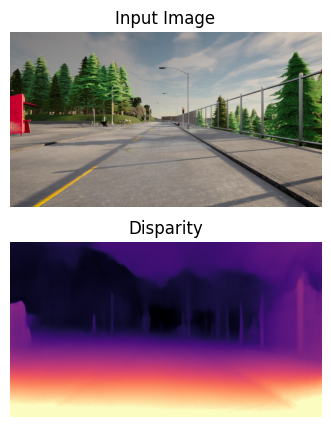

In [9]:
sample_pred_disp = monodepth2_model(input_image_pytorch)

fig = monodepth2_model.plot(sample_rgb, sample_pred_disp)
plt.show()

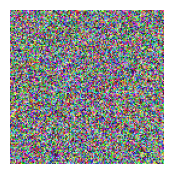

In [10]:
patch_dims = (128, 128)
patch_texture = torch.rand(3, patch_dims[0], patch_dims[1])

# Plotting the texture patch
plt.figure(figsize=(2, 2))
plt.imshow(patch_texture.permute(1, 2, 0))
plt.axis("off")
plt.show()

Original image size: 1280x720


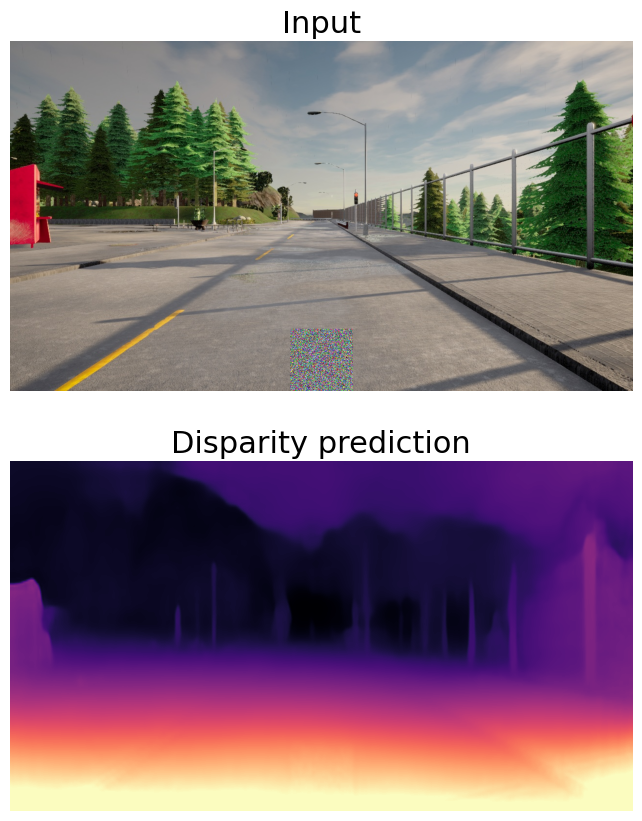

In [11]:
original_width, original_height = input_image_pytorch.shape[-1], input_image_pytorch.shape[-2]

print(f"Original image size: {original_width}x{original_height}")

image = input_image_pytorch.clone()
x_offset = original_width // 2 - patch_dims[1] // 2
image[0, :, -patch_dims[0] :, x_offset : x_offset + patch_dims[1]] = patch_texture

disp_resized = monodepth2_model(image)

# Saving colormapped depth image
disp_resized_np = disp_resized.detach().squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(image[0].detach().cpu().permute(1, 2, 0))
plt.title("Input", fontsize=22)
plt.axis("off")

plt.subplot(212)
plt.imshow(disp_resized_np, cmap="magma", vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis("off")
plt.show()

(-0.5, 1279.5, 719.5, -0.5)

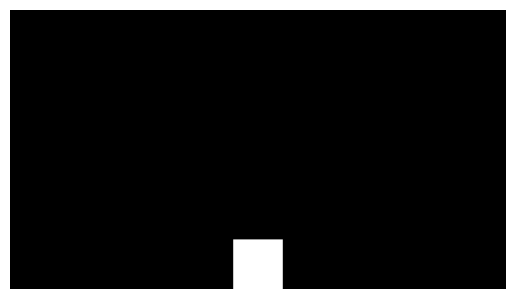

In [12]:
mask = torch.zeros_like(disp_resized)
mask[:, :, -patch_dims[0] :, x_offset : x_offset + patch_dims[1]] = 1.0

# Plotting the mask
plt.figure()
plt.imshow(mask[0].detach().squeeze().cpu().numpy(), cmap="gray")
plt.axis("off")

In [13]:
from adv_manhole.attack.losses import AdvManholeLosses

adv_manhole_losses = AdvManholeLosses()

In [14]:
def smooth_loss(texture):
    # Compute the gradient of the texture patch
    texture_dx = texture - torch.roll(texture, shifts=1, dims=1)
    texture_dy = texture - torch.roll(texture, shifts=1, dims=2)

    # Compute the smoothness loss
    loss = torch.mean(texture_dx**2) + torch.mean(texture_dy**2)
    return loss

In [15]:
def mapped_texture_mask(
    surface_xyz,
    tex_size=1.0,
    tex_shift=[0.0, 0.0, 0.0],
):

    x_offset = tex_shift[0]
    y_offset = tex_shift[1]

    # Mask the centerized local coordinates given the texture size
    texture_mask = torch.where(
        (surface_xyz[0, ...] > x_offset)
        & (surface_xyz[0, ...] < x_offset + tex_size)
        & (surface_xyz[1, ...] > y_offset)
        & (surface_xyz[1, ...] < y_offset + tex_size),
        1.0,
        0.0,
    )

    return texture_mask


def depth_texture_mapping(
    texture,
    surface_xyz,
    tex_size=1.0,
    tex_shift=[0.0, 0.0, 0.0],
    texture_res=256,
):
    # Convert to channel last
    surface_xyz = surface_xyz.permute(1, 2, 0)
    # normal_mask = normal_mask.permute(1, 2, 0)
    texture_flat = texture.permute(1, 2, 0).view(-1, 3)
    max_uv_idx = texture_res**2 - 1

    # Get the UV coordinates by modulating the surface coordinates with the texture size
    surface_xyz_mod = (surface_xyz - tex_shift) % tex_size
    surface_xyz_mod = surface_xyz_mod / tex_size

    # Get the UV indices by multiplying the UV coordinates with the texture resolution
    uv_idx = surface_xyz_mod * texture_res
    uv_idx = torch.round(uv_idx).to(torch.int64)
    uv_idx = torch.clamp(uv_idx, 0, texture_res - 1)

    # Get the UV indices for each axis
    uv_idx_z = uv_idx[..., [0, 1]]

    # Invert the z uv indices
    uv_idx_z[..., 0] = texture_res - uv_idx_z[..., 0]

    # Get the UV indices for each axis flattened
    uv_idx_z_flat = (uv_idx_z[..., 0] * texture_res + uv_idx_z[..., 1]).clamp_max(
        max_uv_idx
    )

    # Get the rendered images for each axis
    rendered_img_z = texture_flat[uv_idx_z_flat.flatten(), :].reshape(
        surface_xyz_mod.shape
    )

    # Reverse the channel last to channel first
    rendered_img_z = rendered_img_z.permute(2, 0, 1)

    return rendered_img_z

In [16]:
sample_surface_xyz.shape

(720, 1280, 3)

In [17]:
sample_surface_xyz_tensor = ToTensor()(sample_surface_xyz).unsqueeze(0).cuda()
sample_surface_xyz_tensor.shape

torch.Size([1, 3, 720, 1280])

(-0.5, 1279.5, 719.5, -0.5)

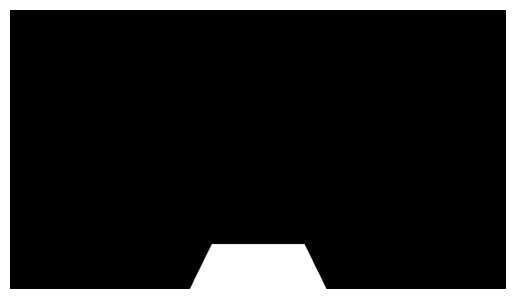

In [18]:
tex_size = torch.tensor(0.5).cuda()
tex_shift = torch.tensor([0.0, -0.25, 0.0]).cuda()

texture_mask = mapped_texture_mask(
    sample_surface_xyz_tensor[0],
    tex_size=tex_size,
    tex_shift=tex_shift,
)

plt.figure()
plt.imshow(texture_mask.detach().cpu().numpy(), cmap="gray")
plt.axis("off")

In [19]:
from torchvision import transforms

# Create color jitter transform for data augmentation
texture_augmentation = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.5, contrast=0.25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ]
)

output_augmentation = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.5, contrast=0.25),
    ]
)

In [23]:
import torch.optim as optim
from tqdm import tqdm

patch_texture_var = torch.nn.Parameter(patch_texture, requires_grad=True)

# Define the optimization pipeline
optimizer = optim.Adam([patch_texture_var], lr=0.01)

# Define the loss function
loss_fn = torch.nn.functional.mse_loss

# Number of optimization steps
n_steps = 1000


# Optimization loop
loop = tqdm(range(n_steps))
for _ in loop:
    optimizer.zero_grad()
    patch_texture_input = patch_texture_var.to(monodepth2_model.device)

    texture_mask = mapped_texture_mask(
        sample_surface_xyz_tensor[0],
        tex_size=tex_size,
        tex_shift=tex_shift,
    )

    augmented_texture = texture_augmentation(patch_texture_input)

    mapped_texture = depth_texture_mapping(
        augmented_texture,
        sample_surface_xyz_tensor[0],
        tex_size=tex_size,
        tex_shift=tex_shift,
        texture_res=patch_texture_var.shape[-1],
    )

    final_image = input_image_pytorch[0] * (1.0 - texture_mask) + mapped_texture * texture_mask

    augmented_output = output_augmentation(final_image)

    disp_resized = monodepth2_model(augmented_output.unsqueeze(0))

    adv_loss = adv_manhole_losses.adversarial_mde_loss(
        disp_resized,
        torch.zeros_like(disp_resized),
        texture_mask.unsqueeze(0).unsqueeze(0),
    )

    smooth_loss = adv_manhole_losses.tv_loss(patch_texture_input)

    background_loss = adv_manhole_losses.background_loss(
        final_image.unsqueeze(0), input_image_pytorch, texture_mask.unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)
    )

    total_loss = adv_loss + smooth_loss + background_loss

    total_loss.backward()
    optimizer.step()

    loop.set_postfix(loss=adv_loss.item())

    # loss = (
    #     adv_manhole_losses.adversarial_mde_loss(
    #         disp_resized,
    #         torch.zeros_like(disp_resized),
    #         mask,
    #     )
    #     + (0.1 * smooth_loss(patch_texture_input))
    #     + (0.5 * loss_fn(patch_texture_input, bg))
    # )
    # loss.backward()
    # optimizer.step()

    # loop.set_postfix(loss=loss.item())

 99%|█████████▉| 991/1000 [00:13<00:00, 74.39it/s, loss=0.00241]

100%|██████████| 1000/1000 [00:13<00:00, 73.63it/s, loss=0.00401]


In [24]:
adv_loss

tensor(0.0040, device='cuda:0', grad_fn=<MulBackward0>)

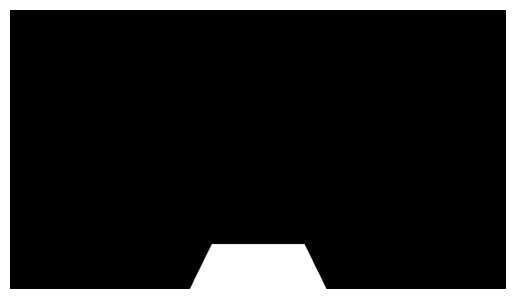

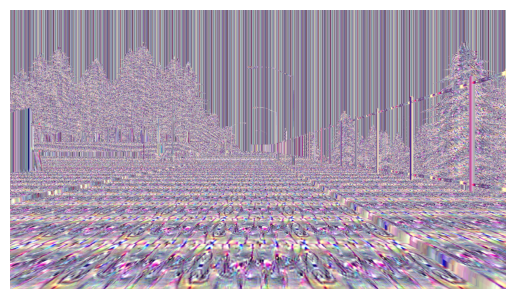

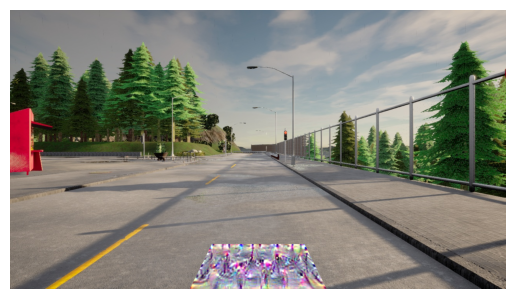

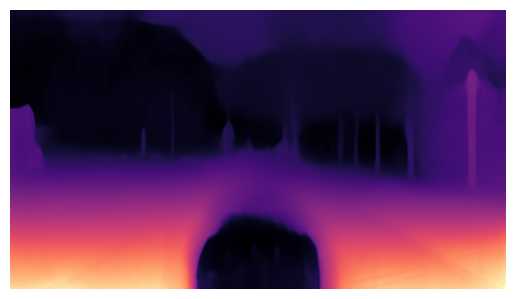

In [25]:
# Plot texture mask
plt.figure()
plt.imshow(texture_mask.detach().squeeze().cpu().numpy(), cmap="gray")
plt.axis("off")

# mapped_texture
plt.figure()
plt.imshow(mapped_texture.detach().cpu().permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# Plot final image
plt.figure()
plt.imshow(final_image.detach().cpu().permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# Plot disp_resized
plt.figure()
plt.imshow(disp_resized.detach().squeeze().cpu().numpy(), cmap="magma")
plt.axis("off")
plt.show()

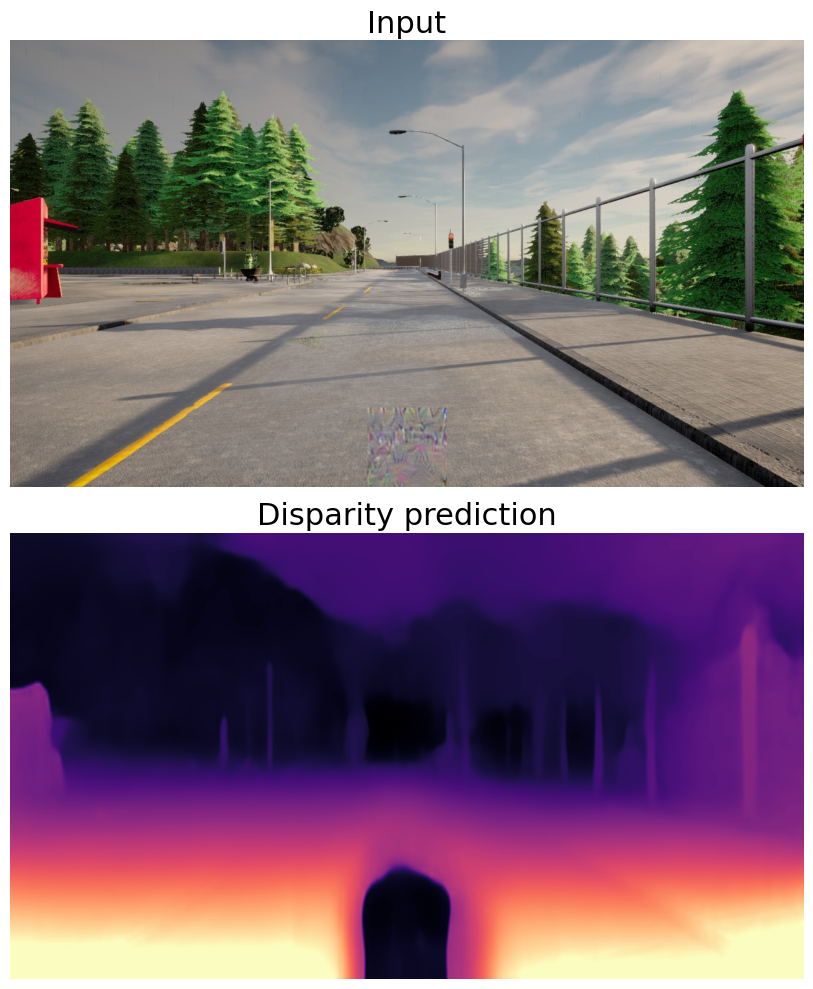

In [21]:
# Apply the patch to the image on the center bottom
image = input_image_pytorch.clone()
x_offset = original_width // 2 - patch_dims[1] // 2
image[0, :, -patch_dims[0] :, x_offset : x_offset + patch_dims[1]] = (
    patch_texture_var.detach()
)

# Run the model on the modified image
disp_resized = monodepth2_model(image)

# Saving colormapped depth image
disp_resized_np = disp_resized.detach().squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(image[0].detach().cpu().permute(1, 2, 0))
plt.title("Input", fontsize=22)
plt.axis("off")

plt.subplot(212)
plt.imshow(disp_resized_np, cmap="magma", vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis("off")

# Tight layout
plt.tight_layout()
plt.show()